# Final Project

* DS 5001
* Amber Curran
* akc6be

# Overview

Data was obtained from Project Gutenberg to explore the texts of the most popular and well known literature as downloaded from the site. These include those counted as the top 5 downloaded pieces of literature downloaded in the last 30 days as of today. Analysis through different text structures, terms, and sentiments are explored below. Visualizations for the code is shown at the very end and included in the supplimental report.

# Set Up

## F0: Acquire Source Texts

The novels were obtained from Project Gutenberg in their list of all books sorted by popularity. Therefore, these are the top 5 most downloaded books in the last 30 days within the Project Gutenberg database:

1. **Frankenstein; Or, The Modern Prometheus** by Mary Wollstonecraft Shelley --ID 11 (80658 downloads)
2. **Pride and Prejudice** by Jane Austen --ID 1342 (56494 downloads)
3. **A Christmas Carol in Prose; Being a Ghost Story of Christmas** by Charles Dickens --ID 25344 (44543 downloads)
4. **The Scarlet Letter** by Nathaniel Hawthorne --ID 46 (35961 downloads)
5. **Alice's Adventures in Wonderland** by Lewis Carroll --ID 84 (26460 downloads)

## Configs

Define OCHO and directory of texts used for most of the code below.

In [1]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

epub_dir = 'texts'

## Imports

Import all necessary modules for most of the code below.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from glob import glob
import re
import nltk

In [3]:
sns.set()
%matplotlib inline

## Inspect

Since Project Gutenberg texts vary widely in their markup, I defined the chunking patterns by hand.

In [4]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chap_pats = {
    11: {
        'start_line': 31,
        'end_line': 3406,
        'chapter': re.compile("^\s*CHAPTER\s+{}\.".format(roman))
    },
    1342: {
        'start_line': 37,
        'end_line': 14230,
        'chapter': re.compile("^Chapter\s+\d+$")
    },
    25344: {
        'start_line': 1611,
        'end_line': 8721,
        'chapter': re.compile("^\s*{}\.".format(roman))          
    },
    46: {
        'start_line': 29,
        'end_line': 3872,
        'chapter': re.compile("^\s*STAVE\s+{}\:".format(roman))
    },
    84: {
        'start_line': 31,
        'end_line': 7389,
        'chapter': re.compile("^Chapter\s+\d+$")
    }
}

## F0:

All text files downloaded from Project Gutenberg are included in the UVA Box folder called "texts".

## F1:

Create a corpus of all documents. These documents are read into a dataframe including each line number and line text.

In [5]:
# Get list of documents
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]

# Create an empty dataframe
df = pd.DataFrame()

# Loop through documents to add text all on one dataframe with indicated line and book ID
for epub_file in epubs:
        
        # Get ID from filename
        book_id = int(epub_file.split('.')[0].replace('texts/',''))
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        subdf = pd.DataFrame(lines, columns=['line_str'])
        subdf.index.name = 'line_num'
        subdf.line_str = subdf.line_str.str.strip()
        subdf['book_id'] = book_id
        
        # Set book_id as index
        subdf = subdf.reset_index().set_index('book_id')
        
        # Append to empty dataframe
        df = df.append(subdf)

df

,line_num,line_str
book_id,,
11,0,The Project Gutenberg eBook of Alice’s Adventu...
11,1,
11,2,This eBook is for the use of anyone anywhere i...
11,3,most other parts of the world at no cost and w...
11,4,"whatsoever. You may copy it, give it away or r..."
...,...,...
84,7738,including how to make donations to the Project...
84,7739,"Archive Foundation, how to help produce our ne..."
84,7740,subscribe to our email newsletter to hear abou...


## F2: 

F2 was created by registering and chunking each book into the DOC dataframe to only include the block of text that is the text of the book without any markup. It was further parsed into each paragraph. The LIB table includes basic information on the book id, author, and title. The TOKEN table was created by listing each term and using nltk to determine the part of speech associated with the word for each word in each book. The VOCAB table includes each term and the number of times each is included in the corpus.

In [6]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get ID from filename
        book_id = int(epub_file.split('.')[0].replace('texts/',''))
        print("BOOK ID", book_id)
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
        
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'book_file']).set_index('book_id')
    return library, docs

Prints all book IDs that verify which books are added into each table.

In [7]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 11
BOOK ID 1342
BOOK ID 25344
BOOK ID 46
BOOK ID 84


### LIB table

In [8]:
# Print LIB table sample
LIB

,book_title,book_file
book_id,,
11,"Alice’s Adventures in Wonderland, by Lewis Car...",texts/11.txt
1342,"Pride and Prejudice, by Jane Austen",texts/1342.txt
25344,"The Scarlet Letter, by Nathaniel Hawthorne",texts/25344.txt
46,"A Christmas Carol, by Charles Dickens",texts/46.txt
84,"Frankenstein, by Mary Wollstonecraft (Godwin) ...",texts/84.txt


In [9]:
# Split the author and title into their own columns
LIB['author'] = LIB.book_title.str.split(', by').apply(lambda x: x[1])
LIB['title'] = LIB.book_title.str.split(', by').apply(lambda x: x[0])
LIB

,book_title,book_file,author,title
book_id,,,,
11,"Alice’s Adventures in Wonderland, by Lewis Car...",texts/11.txt,Lewis Carroll,Alice’s Adventures in Wonderland
1342,"Pride and Prejudice, by Jane Austen",texts/1342.txt,Jane Austen,Pride and Prejudice
25344,"The Scarlet Letter, by Nathaniel Hawthorne",texts/25344.txt,Nathaniel Hawthorne,The Scarlet Letter
46,"A Christmas Carol, by Charles Dickens",texts/46.txt,Charles Dickens,A Christmas Carol
84,"Frankenstein, by Mary Wollstonecraft (Godwin) ...",texts/84.txt,Mary Wollstonecraft (Godwin) Shelley,Frankenstein


In [10]:
# Save as LIB table
LIB.to_csv('LIB.csv')

### DOC table

In [11]:
# Print DOC table sample
DOC

para_str
book_id chap_num para_num                                                   
11      13       0                                    Down the Rabbit - Hole
                 1         Alice was beginning to get very tired of sitti...
                 2         So she was considering in her own mind (as wel...
                 3         There was nothing so _very_ remarkable in that...
                 4         In another moment down went Alice after it, ne...
...                                                                      ...
84      48       78        “But it is true that I am a wretch. I have mur...
                 79        “Fear not that I shall be the instrument of fu...
                 80        “Farewell! I leave you, and in you the last of...
                 81        “But soon,” he cried with sad and solemn enthu...
                 82        He sprang from the cabin - window as he said t...

[5115 rows x 1 columns]

In [12]:
# Save as DOC table
DOC.to_csv('DOC.csv')

### TOKEN Table

In [13]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [14]:
# Use the tokenize function to create a new TOKEN table
TOKEN = tokenize(DOC, ws=True)

In [15]:
# Print TOKEN table sample
TOKEN.sample(10)

pos_tuple  pos token_str
book_id chap_num para_num sent_num token_num                               
25344   15       14       0        15              (the, DT)   DT       the
46      3        24       0        1              (time, NN)   NN      time
25344   21       17       0        31               (to, TO)   TO        to
        12       17       0        0             (“Come, VB)   VB     “Come
1342    74       3        3        4                (I, PRP)  PRP         I
25344   2        23       7        54         (feeding, VBG)  VBG   feeding
1342    95       28       2        6                (so, RB)   RB        so
25344   7        15       0        5           (Hester, NNP)  NNP    Hester
84      35       17       2        12              (but, CC)   CC       but
1342    109      20       0        1               (may, MD)   MD       may

In [16]:
# Save as TOKEN table
TOKEN.to_csv('TOKEN.csv')

### VOCAB table

In [17]:
# Use the TOKEN table to create a new VOCAB table 
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [18]:
# Print VOCAB table sample
VOCAB.sample(10)

,term_str,n,num
term_id,,,
14066,wondered,12,0
248,adornment,4,0
3943,dwelling,26,0
1713,calm,39,0
13976,willing,8,0
8488,numa,1,0
9409,plentifully,1,0
10850,sacrifice,19,0
273,advise,12,0


In [19]:
# Save as VOCAB table
VOCAB.to_csv('VOCAB.csv')

## F3: 

F3 further annotated the VOCAB table to include more information on the terms in the corpus. Annotations were derived from nltk library as a new column was added to define if each word is a stop word ( = 1) or not ( = 0), ProterStemmmer was used to derive the stem of each word into a new column, and the maximum part of speech from the TOKEN table was derived to be added as a new column in the VOCAB table.

### Annotate with Stop Words

In [20]:
# Create a new data frame with all stop words
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

# Create a new 'stop' column to map the list of stop words to VOCAB table
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [21]:
VOCAB.sample(10)

,term_str,n,num,stop
term_id,,,,
3544,discerns,1,0,0
4544,exordium,1,0,0
5842,hang,1,0,0
1701,calculated,5,0,0
6294,idler,1,0,0
6356,immoral,1,0,0
10411,rendezvous,1,0,0
3026,darted,6,0,0
4804,features,35,0,0


In [22]:
VOCAB[VOCAB.stop == 1].sample(10)

,term_str,n,num,stop
term_id,,,,
7101,just,173,0,1
8734,other,493,0,1
13769,was,4433,0,1
2977,d,2,0,1
10897,same,236,0,1
52,about,394,0,1
317,against,119,0,1
12589,then,527,0,1
11632,so,1480,0,1


### Annotate with Stem Words

In [23]:
from nltk.stem.porter import PorterStemmer

# Use the PorterStemmer to extract stem words into a new column
stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [24]:
VOCAB.sample(10)

,term_str,n,num,stop,p_stem
term_id,,,,,
7837,meagre,3,0,0,meagr
12705,tie,3,0,0,tie
6330,imaginative,3,0,0,imagin
6870,intervene,1,0,0,interven
8841,où,1,0,0,où
2767,counting,8,0,0,count
12371,swollen,1,0,0,swollen
2459,conferred,4,0,0,confer
8656,onion,2,0,0,onion


### Annotate with Max Part of Speech

In [25]:
# Create a new data frame with maximum part of speech for each term
table = TOKEN.groupby(['term_str', 'pos']).count().iloc[:,0].unstack().idxmax(1)
TABLE = pd.DataFrame(table, columns=['pos_max'])

# Merge with VOCAB table
VOCAB = pd.merge(VOCAB, TABLE, on='term_str')
VOCAB.index.name = 'term_id'

In [26]:
VOCAB.sample(10)

,term_str,n,num,stop,p_stem,pos_max
term_id,,,,,,
10690,ridges,2,0,0,ridg,NNS
1323,bitterness,21,0,0,bitter,NN
13328,unprejudiced,2,0,0,unprejud,JJ
9576,precincts,1,0,0,precinct,NNS
1990,chewing,1,0,0,chew,VBG
7062,jot,1,0,0,jot,NN
14090,worked,14,0,0,work,VBD
7234,lake,27,0,0,lake,NN
5978,heavenward,5,0,0,heavenward,NN


## F4: 

After creating a bag of words table, vector space representations included creating a document term count matrix, term frequency table, document frequency table, inverse document frequency table, and a combined term frequency-inverse document frequency table. The bag of words table was then able to be annotated with the term frequency and term frequency -inverse document frequency data.

*** need to finish ***

"F4. STADM with Vector Space models. Vector space representations
of TOKEN data and resulting statistical data, such as term
frequency and TFIDF."

In [27]:
# Set configs
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'GnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 
bag = BOOKS # Set bags to BOOKS

In [28]:
VOCAB.sample(10)

,term_str,n,num,stop,p_stem,pos_max
term_id,,,,,,
8302,national,2,0,0,nation,JJ
203,addresses,7,0,0,address,NNS
1745,canvassed,3,0,0,canvass,VBN
5333,furniture,14,0,0,furnitur,NN
5497,glaciers,3,0,0,glacier,NNS
5502,gladness,4,0,0,glad,NN
2935,cur,1,0,0,cur,NN
1450,borrowed,1,0,0,borrow,VBN
6138,homeward,6,0,0,homeward,NN


In [29]:
# add term_id to TOKEN table
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
# add term rank to VOCAB
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1
# add frequency * rank
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank

### Create Bag Of Words

In [30]:
# create BOW
BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id': 'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')

# Create Document-Term Count Matrix

In [31]:
# create count matrix
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
DTCM

term_id,0,1,2,3,4,5,6,7,8,9,...,14217,14218,14219,14220,14221,14222,14223,14224,14225,14226
book_id,,,,,,,,,,,,,,,,,,,,,
11,542,0,0,0,0,0,0,0,0,0,...,0,0,7,0,1,0,0,1,0,0
46,399,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
84,260,1,2,2,1,0,10,2,1,1,...,3,0,0,4,0,0,0,0,0,0
1342,724,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,4,1
25344,1134,0,0,0,0,0,0,0,0,0,...,5,0,0,4,0,1,5,1,0,0


### Create Term Frequency Table

In [32]:
# Compute TF
print('TF method:', tf_method)
if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log10(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

TF method: sum


### Create Document Frequency Table

In [33]:
# Compute DF
DF = DTCM[DTCM > 0].count()

### Create Inverse Document Frequency Table

In [34]:
# Compute IDF
N = DTCM.shape[0]
print('IDF method:', idf_method)
if idf_method == 'standard':
    IDF = np.log10(N / DF)
elif idf_method == 'max':
    IDF = np.log10(DF.max() / DF) 
elif idf_method == 'smooth':
    IDF = np.log10((1 + N) / (1 + DF)) + 1

IDF method: standard


### Create Term Frequency Inverse Document Frequency Table

In [35]:
# Compute TFIDF
TFIDF = TF * IDF

In [36]:
TFIDF

term_id,0,1,2,3,4,5,6,7,8,9,...,14217,14218,14219,14220,14221,14222,14223,14224,14225,14226
book_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00018,0.000000,0.000026,0.00000,0.00000,0.000015,0.000000,0.000000
46,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000008,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
84,0.0,0.000009,0.000019,0.000019,0.000009,0.000000,0.000093,0.000011,0.000009,0.000005,...,0.000016,0.000000,0.00000,0.000012,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
1342,0.0,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000003,0.000000,0.000003,...,0.000000,0.000006,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000023,0.000006
25344,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000028,0.000000,0.00000,0.000013,0.000000,0.00001,0.00005,0.000006,0.000000,0.000000


### Create TFIDF Matrix using BOW

In [37]:
# Matrix
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()
BOW

n  c        tf     tfidf
book_id term_id                            
11      0        542  1  0.019923  0.000000
        21       632  1  0.023231  0.000000
        36         1  1  0.000037  0.000008
        41         1  1  0.000037  0.000000
        52        94  1  0.003455  0.000000
...              ... ..       ...       ...
25344   14217      5  1  0.000071  0.000028
        14220      4  1  0.000057  0.000013
        14222      1  1  0.000014  0.000010
        14223      5  1  0.000071  0.000050
        14224      1  1  0.000014  0.000006

[27530 rows x 4 columns]

In [38]:
VOCAB['tfidf_sum'] = TFIDF.sum()


## F5: 

PCA, LDA, word2vec were analysize in the F5. PCA was analyzed by creating a covariance matrix, and decomposing the matrix to convert the eigen data into a workable dataframe. Principal components were then selected...

*** need to finish ***

LDA was analyzed...

word2vec was analyzed by using the TOKEN table and converting to a corpus for Gensim to be able to analyze excluding proper nouns. A model was then created to generate word embeddings with Gensim's library. Using this model, the t-SNE graph is derived as shown in section F6 with the visualizations.

The sentiment analysis was also included in the F5 where the lexicon was used to associate each TOKEN with 8 main emotions and the addition of polarity which is the difference of positive and negative sentiment. This created a new table that are visually represented in F6 with mean emotion throughout the entire book and the sentiments associated throughout the book by chapter.


"F5: STADM with analytical models. STADM with columns and tables added for outputs of fitting and transforming models with the data."

### PCA

In [39]:
# Configs and Imports
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh as eig

#### Compute Covariance Matrix

In [40]:
from sklearn.decomposition import PCA
from scipy.linalg import norm

TFIDF_b = TFIDF.apply(lambda x: x / norm(x), 1)
TFIDF_b = TFIDF_b - TFIDF_b.mean()
COV_b = TFIDF_b.cov()
COV_b.iloc[:5, :10].style.background_gradient()


term_id,0,1,2,3,4,5,6,7,8,9
term_id,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000004,0.000009,0.000009,0.000004,-0.000000,0.000045,0.000005,0.000004,0.000002
2,0.000000,0.000009,0.000018,0.000018,0.000009,-0.000001,0.000089,0.000010,0.000009,0.000005
3,0.000000,0.000009,0.000018,0.000018,0.000009,-0.000001,0.000089,0.000010,0.000009,0.000005
4,0.000000,0.000004,0.000009,0.000009,0.000004,-0.000000,0.000045,0.000005,0.000004,0.000002


#### Decompose the Matrix

In [41]:
%time eig_vals_b, eig_vecs_b = eig(COV_b)

CPU times: user 11min 56s, sys: 2.13 s, total: 11min 59s
Wall time: 12min 6s


#### Convert Eigen Data to Dataframes

In [42]:
TERM_IDX = COV_b.index
EIG_VEC_b = pd.DataFrame(eig_vecs_b, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL_b = pd.DataFrame(eig_vals_b, index=TERM_IDX, columns=['eig_val'])
EIG_VAL_b.index.name = 'term_id'
EIG_VEC_b.iloc[:5, :10].style.background_gradient()

term_id,0,1,2,3,4,5,6,7,8,9
term_id,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001875,-0.002588,-0.001333,0.000000,-0.000094,-0.000661,-0.000069,-0.000082,0.000057,0.000174
2,-0.495050,0.636016,0.092565,0.005237,-0.001273,-0.001419,-0.003589,0.001984,-0.003620,0.001941
3,0.487601,0.265698,0.371427,0.021705,-0.020964,-0.014679,-0.008193,0.028147,-0.011806,-0.036484
4,-0.391465,-0.416299,0.407189,-0.000997,-0.001480,0.006687,-0.006017,-0.006386,-0.000506,-0.007157


#### Select Principal Component

In [43]:
# Combine eigenvalues and eigen vectors
EIG_PAIRS_b = EIG_VAL_b.join(EIG_VEC_b.T)
EIG_PAIRS_b['exp_var'] = np.round((EIG_PAIRS_b.eig_val / EIG_PAIRS_b.eig_val.sum()) * 100, 2)


<AxesSubplot:xlabel='term_id'>

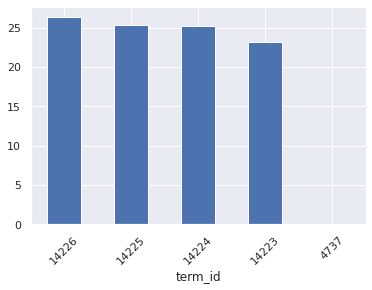

In [44]:
EIG_PAIRS_b.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

### Pick the Top 10 K components

In [ ]:
TOPS_b = EIG_PAIRS_b.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
TOPS_b.index.name = 'comp_id'
TOPS_b.index = ["PC{}".format(i) for i in TOPS_b.index.tolist()]

### Show loadings

In [ ]:
LOADINGS_b = TOPS_b[TERM_IDX].T
LOADINGS_b.index.name = 'term_id'
LOADINGS_b.head().style.background_gradient()

In [ ]:
LOADINGS_b['term_str'] = LOADINGS_b.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)
lb0_pos = LOADINGS_b.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
lb0_neg = LOADINGS_b.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
lb1_pos = LOADINGS_b.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
lb1_neg = LOADINGS_b.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [ ]:
print('Books PC0+', lb0_pos)
print('Books PC0-', lb0_neg)
print('Books PC1+', lb1_pos)
print('Books PC1-', lb1_neg)

### LDA

In [ ]:
# Configs and imports
n_terms = 4000
n_topics = 30
max_iter = 5

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
TOKENS = pd.read_csv(src_corpus)
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

THETA = pd.DataFrame(lda.fit_transform(tf), index=BOOKS.index)
THETA.columns.name = 'topic_id'
THETA.sample(20).style.background_gradient()

### word2vec

In [ ]:
TOKEN.sample(10)

In [ ]:
# Configs and Imports
from gensim.models import word2vec
from sklearn.manifold import TSNE

BAG = OHCO[:2] # Paragraphs
window = 5

In [ ]:
# Convert to a corpus for Gensim excluding proper nouns.
corpus = TOKEN[~TOKEN.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [ ]:
# Generate word embeddings with Gensim's library
model = word2vec.Word2Vec(corpus, vector_size=246, window=window, min_count=200, workers=4)

### Sentiment Analysis

In [ ]:
# Configs
salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

In [ ]:
# Get lexicon
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
# Add polarity
salex['polarity'] = salex.positive - salex.negative
# Get lexicon columns
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [ ]:
TOKENS = TOKEN.join(LIB, on='book_id', how='left')

In [ ]:
TOKENS = TOKENS.drop(columns=['book_title', 'book_file'])

In [ ]:
emo_TOKEN = TOKENS.join(salex, on='term_str', how='left')
emo_TOKEN[emo_cols] = emo_TOKEN[emo_cols].fillna(0)
emo_TOKEN[['term_str'] + emo_cols].sample(10)

In [ ]:
emo_TOKEN.head()

In [ ]:
# Set up for chapter sentiment
chapOHCO = OHCO[1:2]
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [ ]:
# Mean emotion by book
ALICE = emo_TOKEN.loc[11].copy()
PRIDE = emo_TOKEN.loc[1342].copy()
SCARLETT = emo_TOKEN.loc[25344].copy()
CHRISTMAS = emo_TOKEN.loc[46].copy()
FRANK = emo_TOKEN.loc[84].copy()

# Sentiment by chapter
ALICE_chaps = ALICE.groupby(chapOHCO)[emo_cols].mean()
PRIDE_chaps = PRIDE.groupby(chapOHCO)[emo_cols].mean()
SCARLETT_chaps = SCARLETT.groupby(chapOHCO)[emo_cols].mean()
CHRISTMAS_chaps = CHRISTMAS.groupby(chapOHCO)[emo_cols].mean()
FRANK_chaps = FRANK.groupby(chapOHCO)[emo_cols].mean()


## F6: Visualizations

Visualizations include the TFIDF heat maps, t-SNE plot, sentiment analysis plots for each document,...

*** need to finish ***

"F6: STADM converted into interactive visualization. STADM represented as a database-driven application with interactive visualization, .e.g. Jupyter notebooks and web applications."

### TFIDF heatmaps

The TFIDF heat maps show the frequency of each term in the VOCAB table including the annotations from F4 with the addition of analysis using Zip's K and the tfidf_sum. The values are sorted on the sum of term frequency-inverse doucment frequency value and therefore these are the top 20 terms as part of the corpus. In the first heatmap, it is noted that all of these terms are part of speech "NNP" or proper nouns which makes sense as the authors are often referring to the characters in the novels. Therefore, in the second table we explore the top 50 terms that are not proper nouns.

In [ ]:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap)

In [ ]:
# Heatmap of top 50 terms without proper nouns
VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']].sort_values('tfidf_sum', ascending=False)\
    .head(50).style.background_gradient(cmap=gradient_cmap, high=.5)

#### t-SNE plot

The t-distributed scholastic neighbor embedding (t-SNE) plot uses the word2vec model to create vecto space representations of each word for which can be plotted on an x-y plane. In the plot we see words that are highly associated with each other are closer in vector space on the plot than words that are not as associated with each other. 

In [ ]:
# Generate coordinates to plot
coords = pd.DataFrame(index=range(len(model.wv)))
coords['label'] = [w for w in model.wv.key_to_index]
coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))
# Fit to t-SNE model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())
# Get x and y values
coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]
# Plot
px.scatter(coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')

### Sentiment Analysis Plots

The sentiment analysis plots are shown for each novel. Here I used 8 emotions with the addition of polarity to describe each novel. The bar plot represents the mean amount of emotion for the book as a whole sorted from greatest to least. For example, the greatest emotion in the novel Alice in Wonderland is joy, while the mean greatest emotion in the novel Frankenstein is fear. The line plot shows the progression of the novel per chapter and the emotions associated with each chapter. As you can see in the plots, some are more fluctuating or stagnant than others.

Similarity and distance measures

*** need to finish ***

In [ ]:
print("BOOK: ALICE")
# Plot mean emotion by book
ALICE[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(ALICE_chaps, emo_cols)

In [ ]:
print("BOOK: PRIDE AND PREJUDICE")
# Plot mean emotion by book
PRIDE[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(PRIDE_chaps, emo_cols)

In [ ]:
print("BOOK: SCARLETT LETTER")
# Plot mean emotion by book
SCARLETT[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(SCARLETT_chaps, emo_cols)

In [ ]:
print("BOOK: CHRISTMAS CAROL")
# Plot mean emotion by book
CHRISTMAS[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(CHRISTMAS_chaps, emo_cols)

In [ ]:
print("BOOK: FRANKENSTEIN")
# Plot mean emotion by book
FRANK[emo_cols].mean().sort_values().plot.barh()
# Pkot sentiment by chapter
plot_sentiments(FRANK_chaps, emo_cols)

## Similarity and Distance Measures

In [ ]:
newLIB = LIB.drop(columns=['book_title', 'book_file'])


In [ ]:
DOCLIB = DOC.join(newLIB, on='book_id', how='left')
DOCLIB

In [ ]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [ ]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
#PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0', 'level_1'])
#PAIRS.index.names = ['doc_a', 'doc_b']
#PAIRS.head()